# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing DataSet

In [2]:
# importing needed libraries
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portofolio Data Overview & Cleaning

- we need to change channels to boolean columns with 1 corresponding to values in each list 

In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


- Difficulty Ranges from 0 to 20 points
- Duration Ranges from 3 to 10 Days
- Reward ranges from 0 ot 10 points 

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
df1 = pd.get_dummies(pd.DataFrame(portfolio['channels'].tolist()).stack()).sum(axis=0,level=0)
df1 = pd.concat([portfolio,df1],axis=1)
df1.drop(['channels'],axis=1,inplace=True)
df1.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
portfolio = df1.copy()
portfolio = portfolio.rename(columns={'id':'offer_id'})

### profile Data Overview & Cleaning

Cleaning Steps
- Rename id Column to Customer id 
- change became_member_on column to be Date format

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.shape

(17000, 5)

In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile = profile.rename(columns={'id':'customer_id'})

In [16]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],yearfirst=True,format='%Y%m%d')

In [17]:
profile['age'].value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

In [18]:
profile['gender'].value_counts().head()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [19]:
profile[profile['age']==118]['gender'].isna().sum()

2175

In [20]:
profile['became_member_on'].min(), profile['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

In [21]:
profile.duplicated().sum()

0

Notes:
- profile Dataset have 2175 rows with null Values
- income ranges from 30K to 120K with avarage value near to median at 65K
- thier are 2175 rows with age 118 (which is not normal)
- we have 8484 Males and 6129 females and 212 others 
- all customers with age 118 has Null values in Gender and income columns
- Dataset of customers was collected from july 2013 to july 2018 for one year 

### Transcript Data Overview & Cleaning

Notes:
- we have 4 values of events:
    - offer received
    - offer viewed
    - offer completed
    - transaction 
- most of events are transactions
- value field has either offer id or ammount of spent money 
- also some offers has rewards after using it

Cleaning Steps
- we should extract offer id in single column and also get ammount spent 
- change event column to multicolumns with boolean value if occured 
- rename Offer id to offer_id

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.shape

(306534, 4)

In [24]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [25]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [26]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [27]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [28]:
transcript = transcript.rename(columns={'person':'customer_id'})

In [29]:
transcript['value'][0]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [30]:
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['reward_gained'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount_spent'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))

In [31]:
transcript['offer id'] = transcript.apply(lambda x: x['offer_id'] if x['offer id']==None else x['offer id'],axis=1)

In [32]:
transcript = transcript.drop(['value','offer_id'],axis=1)

In [33]:
df2 = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript,df2],axis=1)
#transcript = transcript.drop(['event'],axis=1)

In [34]:
transcript.head()

,event,customer_id,time,reward_gained,amount_spent,offer id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [35]:
transcript = transcript.rename(columns={'offer id':'offer_id'})

## Merging DataFrames

- Merging Portfolio and Transcript profile on Offer_id column
- Merging Profile and Transcript profile on Customer_id column
- Map each customer & offer to Number instead of encoded codes

In [36]:
transcript_profile = pd.merge(transcript, profile, on='customer_id')

In [37]:
transcript_profile.head()

,event,customer_id,time,reward_gained,amount_spent,offer_id,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,2017-05-09,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,2017-05-09,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,19.89,None,0,0,0,1,75,2017-05-09,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,5.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,2017-05-09,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,NaN,17.78,None,0,0,0,1,75,2017-05-09,F,100000.0


In [38]:
df = pd.merge(transcript_profile, portfolio, on='offer_id', how='left')

In [39]:
df.head()

,event,customer_id,time,reward_gained,amount_spent,offer_id,offer completed,offer received,offer viewed,transaction,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,19.89,None,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,5.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,NaN,17.78,None,0,0,0,1,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def customerid_mapper(df,column):
    
    '''
    this function to change encoded customers values to numbers 
    
    input:1) pandas dataframe 
    2) encoded columns to be changed
    
    output: array of numbers according to each encoded customer
    '''
    coded_dict = dict()
    cter = 1
    customer_encoded = []
    
    for val in df[column]:
        if val == None:
            coded_dict[val] = -1
        elif val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        customer_encoded.append(coded_dict[val])
    return customer_encoded

customerid_encoded = customerid_mapper(df,'customer_id')


In [41]:
del df['customer_id']
df['customer_id'] = customerid_encoded

In [42]:
offerid_encoded = customerid_mapper(df,'offer_id')
df['offer_id'] = offerid_encoded

In [43]:
df[df['offer_type']=='informational'].head()

,event,time,reward_gained,amount_spent,offer_id,offer completed,offer received,offer viewed,transaction,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,customer_id
5,offer received,168,NaN,NaN,2,0,1,0,0,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,1
6,offer viewed,216,NaN,NaN,2,0,0,1,0,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,1
22,offer received,336,NaN,NaN,6,0,1,0,0,118,...,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,2
23,offer viewed,336,NaN,NaN,6,0,0,1,0,118,...,NaN,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0,2
24,offer received,408,NaN,NaN,2,0,1,0,0,118,...,NaN,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,2


In [44]:
df.columns

Index(['event', 'time', 'reward_gained', 'amount_spent', 'offer_id',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'age', 'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web',
       'customer_id'],
      dtype='object')

In [45]:
df.to_csv('data/data.csv', index=False)  

# Data Exploration

- what is the average income of starbucks customers?
- what is the average age of starbucks customers?
- is males customers more or females are more?
- what is the most viewed and completed offer?

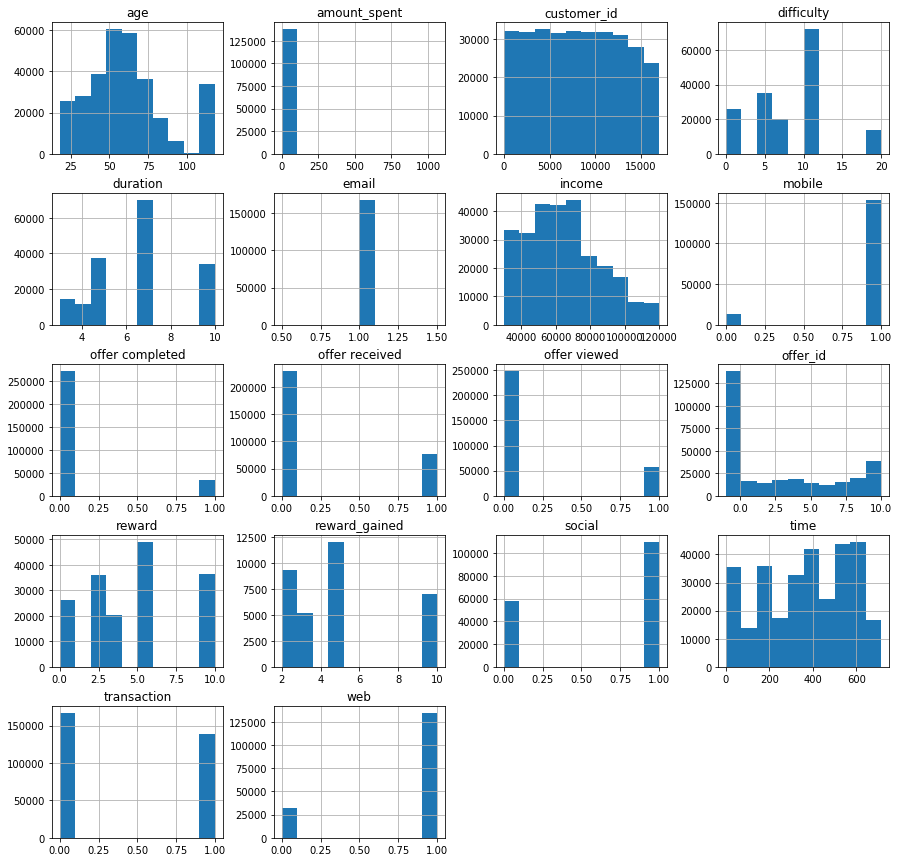

In [46]:
df.hist(figsize=(15,15));

In [47]:
df['customer_id'].max()

17000

In [48]:
df_new = df[['customer_id','age','income','gender']]
df_new = df_new.drop_duplicates()

In [49]:
df_new.head()

,customer_id,age,income,gender
0,1,75,100000.0,F
18,2,118,NaN,None
29,3,68,70000.0,M
41,4,118,NaN,None
51,5,118,NaN,None


In [50]:
def histogram(df,column,xlabel,ylabel,title,bins=30):
    '''
    draw histogram function
    input: 1)df : data frame
    2) column : column of data frame to plot
    3) xlabel of graph
    4) ylabel of graph
    5) title of chart
    6) bins count
    
    output: histogram chart
    
    '''
    
    df[column].hist(bins = bins)
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

62.531411764705879

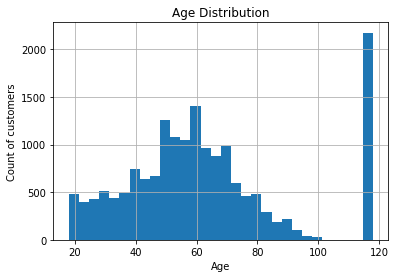

In [51]:
histogram(df_new,'age','Age','Count of customers','Age Distribution',30)
df_new['age'].mean()


65404.991568296799

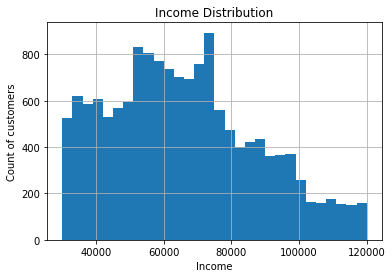

In [81]:
histogram(df_new,'income','Income','Count of customers','Income Distribution',30)
df_new['income'].mean()

In [53]:
df_1 = df[['offer_id']]

In [54]:
df_1.head()

,offer_id
0,1
1,1
2,-1
3,1
4,-1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


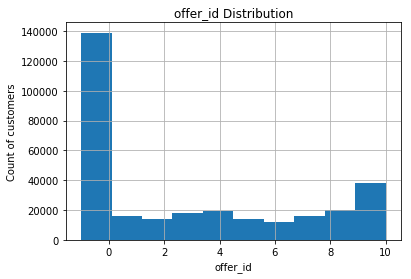

In [55]:
df_1 = df[['offer_id']]
df_1['offer_id'] = df_1['offer_id'].apply(lambda x: 0 if x==None else x)
histogram(df_1,'offer_id','offer_id','Count of customers','offer_id Distribution',10)

In [56]:
df['email'].unique()

array([  1.,  nan])

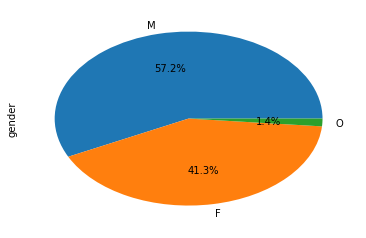

In [57]:
df_new['gender'].value_counts().plot(kind='pie',autopct='%1.1f%%');

In [58]:
df_new['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [59]:
def plottt(df,col1,col2,kind,title,ylabel,mean_or_sum):
    '''
    input 
    df: dataframe
    col1: 1st column
    col2: 2nd column
    kind: type of plot
    title: title of plot
    ylabel: label of y axis
    mean_or_sum : mean of sum of column 2
    output: 
    graph of both columns using kind of graph needed by user
    
    '''
    if mean_or_sum == 'mean':
        df.groupby(col1)[col2].mean().sort_values().plot(kind=kind,figsize=(15,5),color='blue');
    elif mean_or_sum == 'sum':
        df.groupby(col1)[col2].sum().sort_values().plot(kind=kind,figsize=(15,5),color='blue');
    plt.title(title);
    plt.ylabel(ylabel);

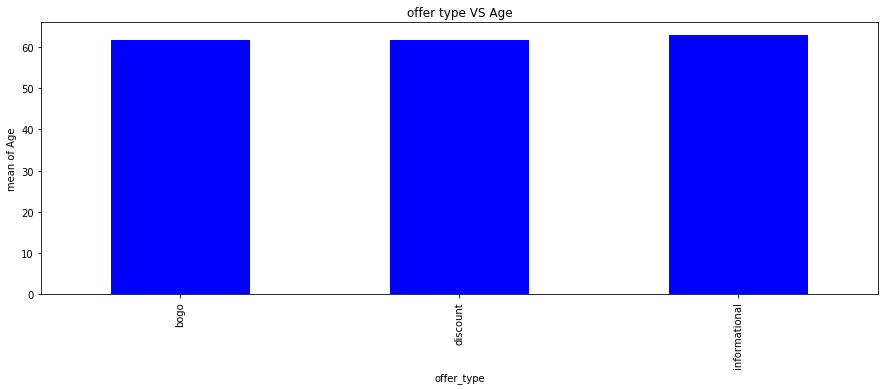

In [60]:

plottt(df,'offer_type','age','bar',"offer type VS Age","mean of Age",'mean')

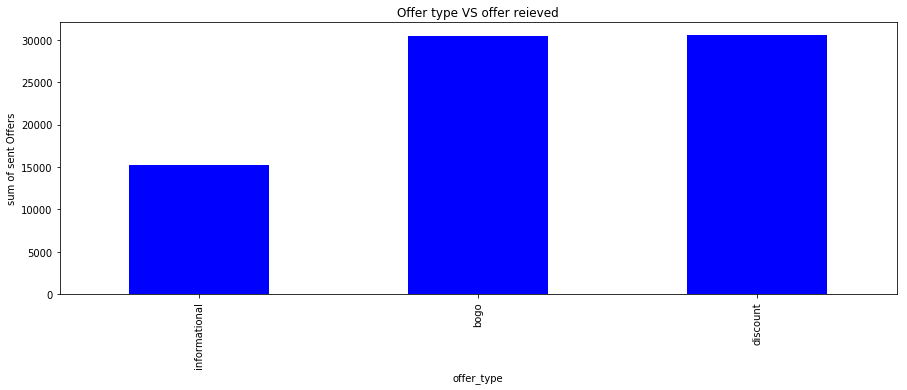

In [61]:
ax1 = plottt(df,'offer_type','offer received','bar',"Offer type VS offer reieved","sum of sent Offers",'sum')

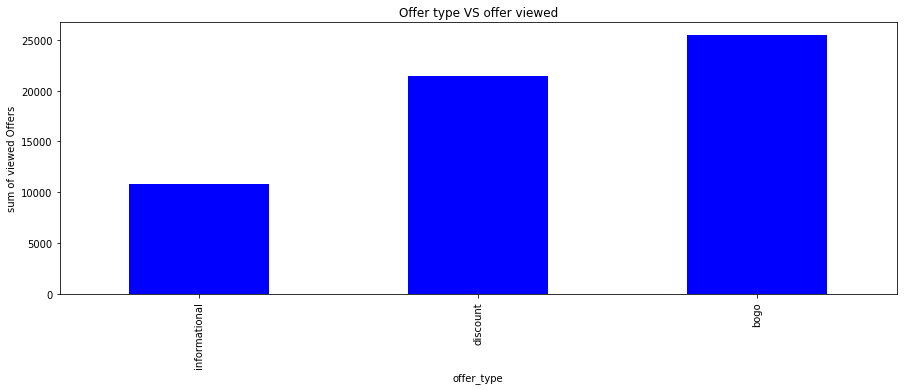

In [62]:
plottt(df,'offer_type','offer viewed','bar',"Offer type VS offer viewed","sum of viewed Offers",'sum')

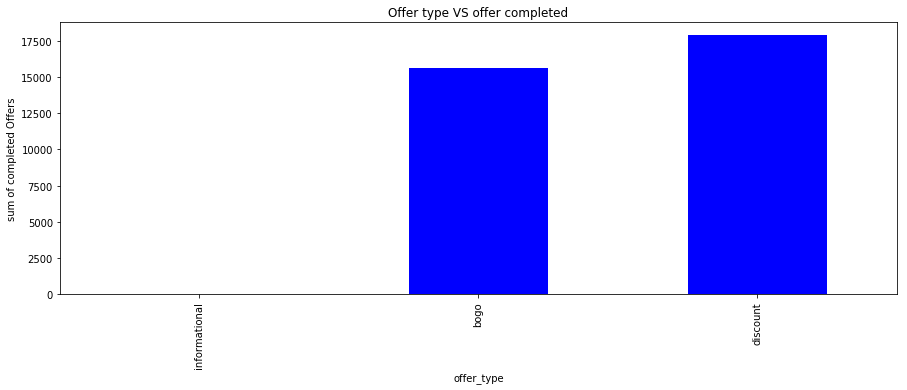

In [63]:
plottt(df,'offer_type','offer completed','bar',"Offer type VS offer completed","sum of completed Offers",'sum')

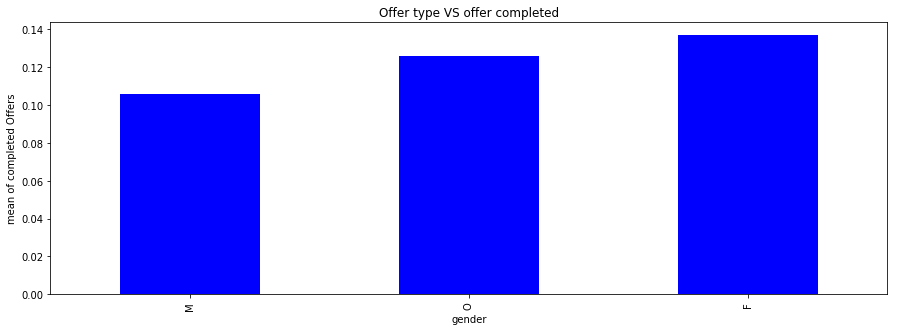

In [64]:
plottt(df,'gender','offer completed','bar',"Offer type VS offer completed","mean of completed Offers",'mean')

Text(0.5,1,'Gender VS income')

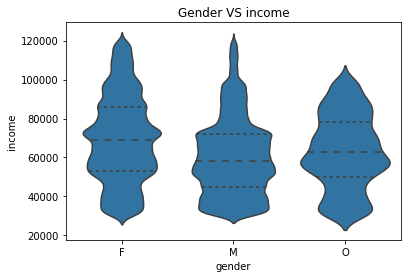

In [65]:
base_color=sb.color_palette()[0]
sb.violinplot(data=df,x='gender',y='income',color=base_color,inner='quartile');
plt.title("Gender VS income")


Text(0.5,1,'Gender VS offer type')

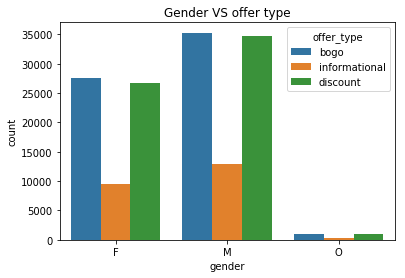

In [66]:
sb.countplot(data=df,x='gender',hue='offer_type');
plt.title("Gender VS offer type")

Text(0.5,1,'count of memberships every year')

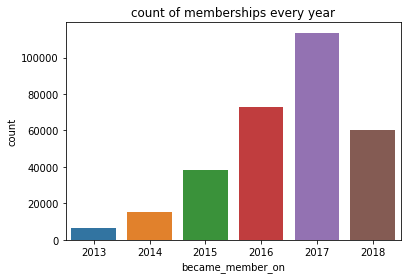

In [67]:
sb.countplot(data=df,x=df['became_member_on'].apply(lambda x: x.year) );
plt.title('count of memberships every year')

### Dataset Exploration findings
- Dataset has 17K customers
- all customers have Emails (seems to be mandatory stage for sign up) so this column will be dummy 
- we have many customers with Age above 110 which is upnormal and all of them as seen before are with null values 
- average age of customers are around 62.5 years 
- average income of customers are 50K to 70K (65404K)
- send offers type of discount and Buy one get one are almost with same count
- viewed offer type of Buy one get one is more than discounts offer 
- completed offer with discount is more than buy one get one
- Males portion in dataset are more then females
- Median income of males are less than females 

# Cleaning Data part 2

### Cleaning Steps
this cleanning part to prepare data for ML algorithms 
- fill null values 
    - fill reward gained with zeros
    - remove age 118 and fill it with mean of age
    - fill missing values of income with income mean
- get year and month of membership date
- map offer type, gender, event to numbers
- drop not needed columns 
- drop null values rows
- change categorical columns to be numerical ones
- scaling columns of values to be between zero and 1
- checking Correlation between input columns to remove highly correlated columns (above 90%)

In [68]:
df['offer_type'].unique()

array(['bogo', nan, 'informational', 'discount'], dtype=object)

In [69]:
df.columns

Index(['event', 'time', 'reward_gained', 'amount_spent', 'offer_id',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'age', 'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web',
       'customer_id'],
      dtype='object')

In [70]:
df.head()

,event,time,reward_gained,amount_spent,offer_id,offer completed,offer received,offer viewed,transaction,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,customer_id
0,offer received,0,NaN,NaN,1,0,1,0,0,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
1,offer viewed,6,NaN,NaN,1,0,0,1,0,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
2,transaction,132,NaN,19.89,-1,0,0,0,1,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,offer completed,132,5.0,NaN,1,1,0,0,0,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
4,transaction,144,NaN,17.78,-1,0,0,0,1,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [71]:
def cleanning_data(df_2):
    '''
    this function cleans our data set as preparation for machine learning model prediction
    input: our dataset
    output: Cleaned Dataset
    '''
    
    df_2['reward_gained'] = df_2['reward_gained'].fillna(0)  # fill null values in reward_gained column with zeros 

    df_2[df_2['age']==118]['age']=int(df_2[df_2['age']<118]['age'].mean())  # replacing unlogical Age values with mean of Age 
    df_2['income'] = df_2['income'].fillna(df['income'].mean()) # replacing Null income values with mean of income 
    df_2['gender'] = df_2['gender'].fillna(df['gender'].mode()[0])  # replacing Null gender values with mode of gender (M) 
    df_2['month'] = df_2['became_member_on'].apply(lambda x: x.month) # Make new month column
    df_2['year'] = df_2['became_member_on'].apply(lambda x: x.year)  # Make new year column
    df_2['event'] = df_2['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3}) 
    df_2['offer_type'] = df_2['offer_type'].map({'bogo':1, 'discount':2, 'informational':3})
    df_2['gender'] = df_2['gender'].map({'F':1, 'M':2, 'O':3})
    df_2 = df_2.drop(['amount_spent','email','customer_id','became_member_on','transaction','offer completed','offer received','offer viewed'],axis=1)
    df_2 = df_2.dropna()  # Drop null values
    df_2['offer_type'] = df_2['offer_type'].astype('int') 
    df_2['event'] = df_2['event'].astype('int')
    df_2['gender'] = df_2['gender'].astype('int')
    scaler = MinMaxScaler() # using min max scaller to scale columns values to numbers between 0 and 1
    scaling_columns = ['income','offer_id', 'difficulty', 'duration', 'time', 'reward_gained','age','gender','offer_type','reward','month','year']
    df_2[scaling_columns] = scaler.fit_transform(df_2[scaling_columns])
    return df_2

In [72]:
df_cleaned = cleanning_data(df.copy())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [73]:
df_cleaned.shape

(167581, 16)

In [74]:
df_cleaned.head()

,event,time,reward_gained,offer_id,age,gender,income,difficulty,duration,offer_type,reward,mobile,social,web,month,year
0,1,0.000000,0.0,0.000000,0.57,0.0,0.777778,0.25,0.571429,0.0,0.5,1.0,0.0,1.0,0.363636,0.8
1,2,0.008403,0.0,0.000000,0.57,0.0,0.777778,0.25,0.571429,0.0,0.5,1.0,0.0,1.0,0.363636,0.8
3,3,0.184874,0.5,0.000000,0.57,0.0,0.777778,0.25,0.571429,0.0,0.5,1.0,0.0,1.0,0.363636,0.8
5,1,0.235294,0.0,0.111111,0.57,0.0,0.777778,0.00,0.000000,1.0,0.0,1.0,1.0,0.0,0.363636,0.8
6,2,0.302521,0.0,0.111111,0.57,0.0,0.777778,0.00,0.000000,1.0,0.0,1.0,1.0,0.0,0.363636,0.8


### checking correlation between data inputs to check for any nearly correlated columns to remove one of them.

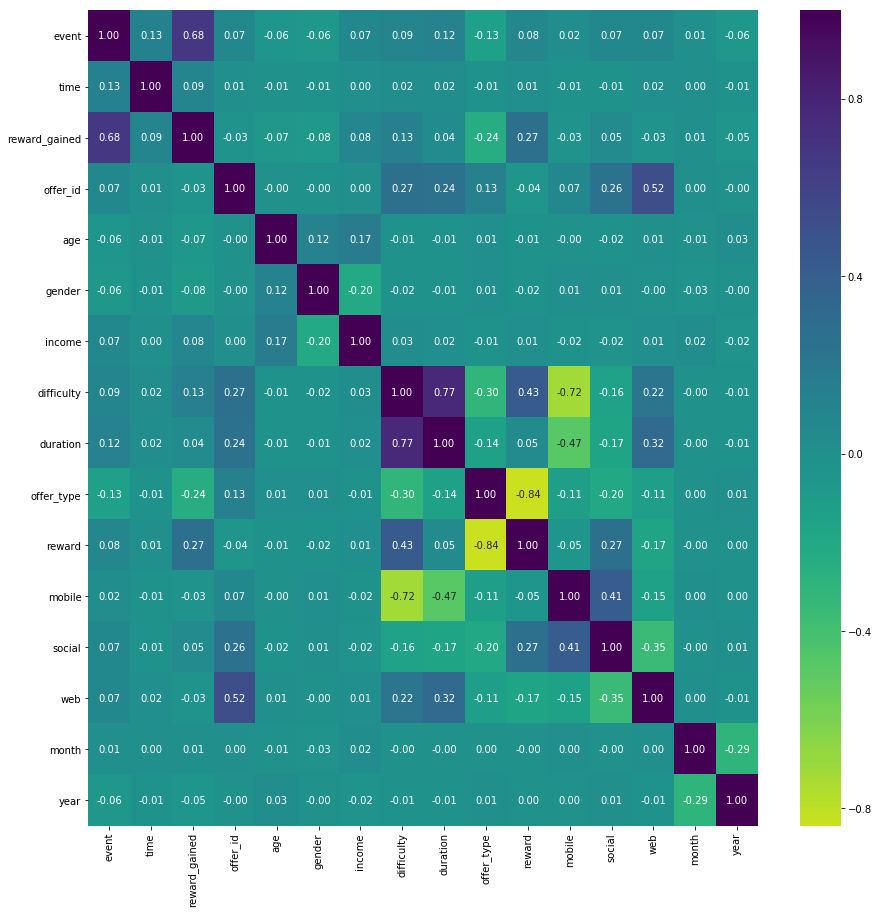

In [75]:
plt.figure(figsize=(15,15))
sb.heatmap(df_cleaned.corr(), annot = True, fmt = '.2f', cmap = 'viridis_r', center = 0);

# Machine Learning Modelling

- i'm going to test many ML Algorithms to get the model best fit with our problem then we should try to improve it using hyper parameters tunning 

In [76]:
data = df_cleaned.drop('event', axis=1)
output = df_cleaned['event']
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size = 0.3, random_state = 42)


In [77]:
def classifier(clf):
    '''
    classifier function to use many classifier and predict testing data and provide F1 score for testing data
    
    input:classifier 
    output: training accuracy score & testing F1 score
    
    '''
    
    classifier = clf.fit(X_train, y_train)
    train_pred =  classifier.predict(X_train)
    test_pred = classifier.predict(X_test)
    train_accuracy_score =  f1_score(y_train, train_pred,average='micro')*100
    test_f1_score = f1_score(y_test, test_pred, average='micro' )*100
    
    
    return train_accuracy_score, test_f1_score

In [78]:
clf_1 = RandomForestClassifier(random_state = 42)
train_f1_1, test_f1_1 = classifier(clf_1)
train_f1_1, test_f1_1

(93.4930864576407, 70.553953257086022)

In [79]:
clf_2 = DecisionTreeClassifier(random_state = 42)
train_f1_2, test_f1_2 = classifier(clf_2)
train_f1_2, test_f1_2

(94.39073875164101, 85.853804077573344)

In [82]:
from sklearn.ensemble import AdaBoostClassifier
clf_3 = AdaBoostClassifier(random_state = 42)
train_f1_3, test_f1_3 = classifier(clf_3)
train_f1_3, test_f1_3

(91.334629089731138, 91.246146195922435)

- we had best results from ADABoost Algorithm with testing F1 score 91.2 so i will proceed with enhancing this model further to get better score

#### Metrics
- i selected F1 Score as metric to include all False Positive and False negative in the Equation without preference and our output here in our proplem is simple quantitative values so F1 score will be good measure for the accuracy of our models

## Model Improvment

- Hyper parameters tunning for Adaboost Model
- An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [84]:
from sklearn.model_selection import GridSearchCV
# Tuning to get better accuracy
n_estimators = [30, 50, 70]
learning_rate = [0.3, 0.5, 1, 1.5]

param_grid = dict(n_estimators = n_estimators, learning_rate = learning_rate)

model = AdaBoostClassifier(random_state=42)
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3,verbose=10)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_*100}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.923584471382538
Best params: {'learning_rate': 1, 'n_estimators': 70}


In [85]:
y_pred2 = grid.predict(X_test)
test_f1_score = f1_score(y_test, y_pred2, average='micro' )*100
test_f1_score

92.350074589756332

- I successfully increased model accuracy to reach 92.3% (extra 1%)

# Conclusion

In [91]:
classifiers = pd.DataFrame({'classifier': [ 'RandomForest', 'DecisionTree','AdaBoost','AdaBoost_enhanced model'], 
          'Train F1 score ':[train_f1_1, train_f1_2,train_f1_3,grid_result.best_score_*100], 
          'Test F1 score': [test_f1_1 , test_f1_2,test_f1_3,test_f1_score] })
          
classifiers

,classifier,Train F1 score,Test F1 score
0,RandomForest,93.493086,70.553953
1,DecisionTree,94.390739,85.853804
2,AdaBoost,91.334629,91.246146
3,AdaBoost_enhanced model,92.358447,92.350075


### Strategy
##### the problem we choose to solve is to try to get Starbucks customers intearact more with the App. to incease Sales and engage customers with product. 1st we discovered our available dataset then do prilim cleaning for it then combined datasets to make one Table with all data and to do some Visual exploration about whole samples we have. then i made ML algorithm to predict which customers shall interact with which offer and finally results with 92.3% accuracy in expecting each customer behaviour with the offers.

#### Dataset exploration output
- Dataset has 17K customers
- all customers have Emails (seems to be mandatory stage for sign up) so this column will be dummy 
- we have many customers with Age above 110 which is upnormal and all of them as seen before are with null values 
- average age of customers are around 60 years 
- average income of customers are 50K to 70K
- send offers type of discount and Buy one get one are almost with same count
- viewed offer type of Buy one get one is more than discounts offer 
- completed offer with discount is more than buy one get one 
- Males portion in dataset are more than females (52.7% VS 41.3%)
- median income of males are less than females
- need to focus more on sending offers to Females as they have more completed offers
- there was focus on inceasing customers membership in 2017
- our model now can expect with each customer and each offer that applied to him if customer with complete the offer or not
- our Adaboost model scored F1 Score 92.2% after hyper parameters tunning which is very good according to our problem here to get more customers react with the offer we sent
- Adaboost model works very well without over/under fitting as training Score is the same as testing score


## Data Improvements

- for more enhancement to the data we shall try to collect better data without Null values or wrong Age 
- we may get use also from data like which branch that has more completed offers 
- distance between customers and branches also may add more accuracy to our data to detect which customers respond better

## References
- https://en.wikipedia.org/wiki/F-score
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier